In [12]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Dropout, LSTM, Flatten
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [14]:
tf.__version__
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [15]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float16)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [16]:
def process_dy(dy):
    (length, y, x) = dy.shape
    newdy = np.zeros((length, y-40, x-50), dtype=np.float16)
    for ind, image in enumerate(dy):
        newimg = image[1:-39, 0:-50]
        newdy[ind] = image[1:-39, 0:-50]
    print(newdy[0].shape)
    return bin_dy(newdy)
    # newdyfile = open('./dfy/cropped_AV_2.pkl', 'wb')
#     np.save('./data/cropped_AV_5.npy', newdy)

# Configuration of Neural Network

In [17]:
# Convolutional Layer 1
filter_size1 = 5  # Convolution filters are 5 x 5 pixels.
num_filters1 = 16 # There are 16 of these filters

# Convolutional Layer 2
filter_size2 = 5  # Convolution filters are 5 x 5 pixels.
num_filters2 = 36 # There are 36 of these filters

# Fully-connected Layer
fc_size = 128     # Number of neurons in fully-connected layer.

# Load Data

In [9]:
# #open files, they have not been normalized yet
# v = np.load("r4m7170321s1AVI.npy")
# #(22796,516,388)
# imc = plt.imshow((v[0]))
# print(v.shape)
# # dffile = v
# dyfile = open('r4m7170321s1.pkl', "rb")
# df = v
# dy = pickle.load(dyfile)
# #loading full file on disk, can access small slices without loading into memory
# dy = np.load('./data/AV_5.npy', mmap_mode='r')
# f = open('./data/delayed_masdfAV_5.pkl', 'rb')
# df = pickle.load(f)
# (length, y, x) = dy.shape
#dataset1
#open files, they have not been normalized yet
# v = np.load("r3m1170210s2AVI.npy")

# imc = plt.imshow((v[0]))
# print(v.shape)
# # dffile = v
# dyfile = open('r3m1170210s2.pkl', "rb")
# df = v
# dy = pickle.load(dyfile)
# print(dy.shape)
#dataset1
# x_data = df[33:-7280]
# print(np.sum(x_data[-1]))
# print(len(x_data))
#dataset2
# x_data = df[49:-226]

In [10]:
#full dataset
dy = np.load('./data/AV_5.npy', mmap_mode='r')
df = np.load('./data/AV_5_vid.npy', mmap_mode='r')

In [102]:
#10hz data
x_data= (df[::3])
dycropped= (dy[::3])
(length, y, x) = dy.shape
(lengthdf, ydf, xdf) = df.shape

In [69]:
#15hz data
x_data = (df[::2])
dycropped= (dy[::2])
(length, y, x) = dy.shape
(lengthdf, ydf, xdf) = df.shape

In [23]:
#30hz data
x_data = (df)
dycropped = process_dy(dy)
(length, y, x) = dycropped.shape
(lengthdf, ydf, xdf) = df.shape

(600, 590)
(17002, 600, 590)
(17002, 300, 295)


In [103]:
num_data = len(x_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = x_data[0:num_train].reshape(num_train, (xdf*ydf))
x_val = x_data[num_train:(num_train+num_val)].reshape(num_val, (xdf*ydf))
x_test = x_data[(num_train+num_val):].reshape(num_test, (xdf*ydf))
y_train = dycropped[0:num_train].reshape(num_train, (y*x))
y_val = dycropped[num_train:(num_train+num_val)].reshape(num_val, (y*x))
y_test = dycropped[(num_train+num_val):].reshape(num_test, (y*x))

In [104]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [105]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled = x_scaler.transform(x_val)

In [106]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
y_val_scaled = y_scaler.transform(y_val)

In [107]:
num_x_signals = x_train.shape[1]
print(num_x_signals)
num_y_signals = (x*y)
print(num_y_signals)

687812
409600


In [108]:
# The number of pixels in each dimension of an image.
img_size_x = ydf
img_size_y = xdf

# The images are stored in one-dimensional arrays of this length.
img_size_flat = (xdf*ydf)

# Tuple with height and width of images used to reshape arrays.
img_shape = (ydf,xdf)

# I dont think I have this
# Number of classes, one class for each of 10 digits.
num_classes = y*x

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1


In [109]:
#TODO comeback and make this useful for my data
def plot_images(images, cls_pred=None):
    
    #Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

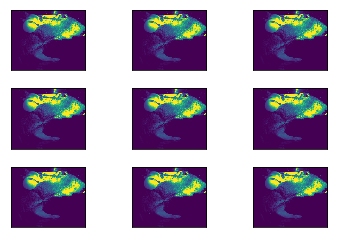

In [110]:
images = x_test[118:127]
plot_images(images=images)

## Helpter-Functions

In [111]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, ydf, xdf)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            if (idx+batch_size) >len(x_train_scaled):
                idx = idx-batch_size
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx].reshape(ydf,xdf)
            y_batch[i] = y_train_scaled[idx]
        
        yield (x_batch, y_batch)

In [112]:
batch_size = 100
channel_length = 1 #20 frames after stim time

In [113]:
generator = batch_generator(batch_size=batch_size, sequence_length=channel_length)

In [114]:
x_batch, y_batch = next(generator)

In [115]:
print(x_batch.shape)
print(y_batch.shape)

(100, 746, 922)
(100, 409600)


In [116]:
x_test_scaled = x_test_scaled.reshape(num_test, ydf, xdf)
x_val_scaled = x_val_scaled.reshape(num_val, ydf, xdf)

In [117]:
validation_data = (x_val_scaled,
                  y_val_scaled)

In [118]:
model = Sequential()
model.add(Conv1D(64,
              kernel_size=3,
              strides=1,
              input_shape=(img_size_x, img_size_y)))
print(model.input_shape)

(None, 746, 922)


In [119]:
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(128, 3, activation='relu'))
# model.add(GlobalAveragePooling1D())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(512, 3, activation='relu'))
# model.add(GlobalAveragePooling1D())
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
# model.add(Dense(2000, activation='sigmoid'))
# model.add(Dropout(0.4))
model.add(Dense(num_y_signals, activation='sigmoid'))

## Loss Function

In [120]:
optimizer = Adam(lr=1e-3)

In [121]:
model.compile(loss='mse', optimizer=optimizer)

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 744, 64)           177088    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 372, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 370, 128)          24704     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 185, 128)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 183, 512)          197120    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 61, 512)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 31232)             0         
__________

In [123]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [124]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [125]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [126]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [127]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [128]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[500,409600]
	 [[Node: training_2/Adam/mul_43 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Adam_4/beta_2/read, training_2/Adam/Variable_18/read)]]
	 [[Node: loss_4/mul/_739 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1032_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'training_2/Adam/mul_43', defined at:
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-128-51b40481f3cc>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'model.fit_generator(generator=generator,\n                    epochs=100,\n                    steps_per_epoch=100,\n                    validation_data=validation_data,\n                    callbacks=callbacks)\n')
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2352, in run_cell_magic
    result = fn(*args, **kwargs)
  File "</home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/decorator.py:decorator-gen-61>", line 2, in time
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1283, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 5, in <module>
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/engine/training.py", line 1415, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/engine/training_generator.py", line 39, in fit_generator
    model._make_train_function()
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/engine/training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/keras/optimizers.py", line 492, in get_updates
    v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 694, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 838, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1061, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1377, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/users/emccarth/miniconda/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[500,409600]
	 [[Node: training_2/Adam/mul_43 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](Adam_4/beta_2/read, training_2/Adam/Variable_18/read)]]
	 [[Node: loss_4/mul/_739 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1032_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [96]:
result = model.evaluate(x_test_scaled,
                        y_test_scaled)


2296/2296 [==============================] - 12s 5ms/step


In [97]:
print(result)

0.020107303152204804


In [98]:
model.save("DRPCNN20hz.h5")

In [71]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [72]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [73]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper-function for plotting convolutional weights

In [74]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [75]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## plotting input images

In [62]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

In [99]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    return ( 1 - SS_res/(SS_tot))

In [100]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,ydf,xdf)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,ydf,xdf)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
#     x = np.expand_dims(x, axis=3)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x)):
        sum_pred.append(np.sum(y_pred[i])/(409600))
        sum_true.append(np.sum(y_true[i])/(409600))
    # Plot and compare the two signals.
    plt.plot(sum_true[:1200], label='true')
    plt.plot(sum_pred[:1200], label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred))
    print(explained_variance_score(y_true, y_pred,multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

r2
0.18244925850599358
0.27237918557618984


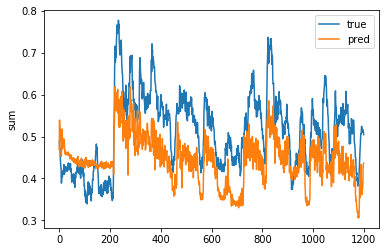

In [101]:
plot_comparison(start_idx=1, length=num_test, train=False)

In [35]:
image1 = x_test[0]
plot_image(image1)

NameError: name 'plot_image' is not defined

In [51]:
def plot_image_difference(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,516,388)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,516,388)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
#     x = np.expand_dims(x, axis=3)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    plt.figure(figsize=(15,5))
    imc = plt.imshow((np.subtract(y_true[4], y_pred[4])).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='difference')
    print("r2")
    print(explained_variance_score(y_true, y_pred))

    plt.legend()
    plt.show()
    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_pred[4]).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='pred')


    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_true[4]).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='true')


    plt.legend()
    plt.show()

No handles with labels found to put in legend.


r2
0.2839682710138758


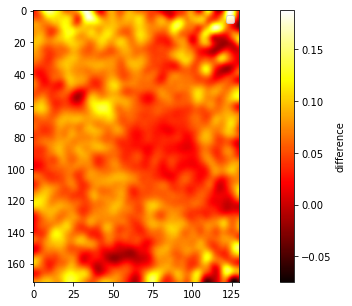

No handles with labels found to put in legend.


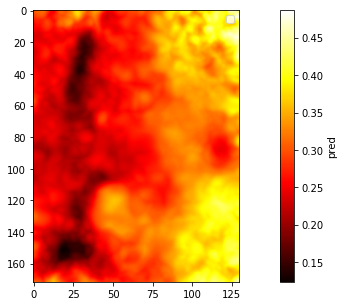

No handles with labels found to put in legend.


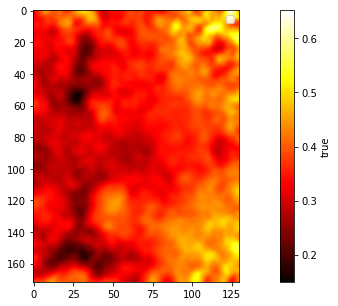

In [52]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()
plot_image_difference(start_idx=1, length=40, train=False)